# Flux Footprint Prediction (FFP) Model — Quick‑start Tutorial

This Jupyter notebook demonstrates how to use the `improved_ffp.py` module, which implements an **Improved Flux Footprint Prediction (FFP) model** based on Kljun et al. (2015). You will learn how to:
1. Load half‑hourly eddy‑covariance data
2. Initialise and configure the `FFPModel`
3. Compute and visualise instantaneous & climatological footprints
4. Derive source‑area contours (e.g. 80 % footprint)
5. Batch‑process multi‑year datasets

> **Tip:** Execute the notebook cell‑by‑cell (`Shift+Enter`) and read the Markdown explanations as you go.

## 1  Requirements & setup
This tutorial assumes a recent scientific Python stack:
- `pandas`, `numpy`, `matplotlib`, `xarray`
- The `improved_ffp.py` file in the current directory

```bash
pip install pandas numpy matplotlib xarray
```
If you are running this notebook inside ChatGPT's sandbox, the dependencies are already installed.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from pathlib import Path
import sys

# Add current directory to sys.path so Python can find improved_ffp.py
sys.path.insert(0, os.path.abspath("../../src"))  # adjust path as needed
from fluxfootprints import FFPModel


## 2  Load example half‑hourly data
The CSV file `US-UTE_HH_202406241430_202409251400.csv` was uploaded together with this notebook. It already contains the meteorological drivers required by the FFP model, but **column names may differ**. The helper routine inside `FFPModel` will attempt to rename common variants automatically.

In [10]:
# Path to the CSV (update if needed)
csv_path = Path('US-UTE_HH_202406241430_202409251400.csv')
df = (pd.read_csv(csv_path, parse_dates=[0])  # first column is timestamp for this example
        .rename(columns=str.strip))  # remove accidental whitespace in headers

# For a quick demo we just take the first 48 half‑hours (one day)
demo_df = df.iloc[:48].copy()
demo_df.head()

,datetime_start,TIMESTAMP_START,TIMESTAMP_END,CO2,CO2_SIGMA,H2O,H2O_SIGMA,FC,FC_SSITC_TEST,LE,...,TA_1_2_1,RH_1_2_1,T_DP_1_2_1,TA_1_3_1,RH_1_3_1,T_DP_1_3_1,TA_1_4_1,PBLH_F,TS_2_1_1,SWC_2_1_1
0,2024-06-24 14:30:00,202406241430,202406241500,427.0199,0.628133,17.26862,1.019290,0.069210,-9999.0,156.40850,...,29.95141,33.26877,12.052600,30.32464,33.45364,12.46181,30.06976,1665.4670,25.72815,22.44161
1,2024-06-24 15:00:00,202406241500,202406241530,425.9499,1.019297,15.18936,0.703052,0.285446,-9999.0,138.30920,...,30.02516,29.22197,10.155240,30.35956,29.77183,10.72635,30.13765,1765.9350,25.52736,22.41975
2,2024-06-24 15:30:00,202406241530,202406241600,426.4163,1.965228,14.87533,0.808026,1.081928,-9999.0,154.11530,...,30.24634,28.28498,9.838229,30.69433,28.63222,10.41335,30.40344,1495.7350,25.12511,22.32785
3,2024-06-24 16:00:00,202406241600,202406241630,426.0534,2.665907,15.61140,1.002919,0.519664,-9999.0,135.56180,...,30.75179,28.75255,10.538220,31.14621,29.16225,11.09066,30.90061,1491.0620,24.63557,22.18172
4,2024-06-24 16:30:00,202406241630,202406241700,427.8476,1.102921,15.21034,0.703084,1.147608,-9999.0,95.06287,...,29.16274,30.77158,10.165810,29.57434,30.96792,10.63069,29.30510,341.9711,24.14865,22.03216


### Required driver columns
The model expects the following **physical variables** (units indicated):

| Expected column | Typical units | Description |
|-----------------|--------------|-------------|
| `sigmav`        | m s⁻¹        | Std.dev. of lateral wind fluctuations σ<sub>v</sub> |
| `ustar`         | m s⁻¹        | Friction velocity u* |
| `ol`            | m            | Obukhov length L (can be negative) |
| `wind_dir`      | °            | Wind direction (0–360 ° from North) |
| `umean`         | m s⁻¹        | Mean wind speed |

The constructor automatically maps common FLUXNET style headers:
`V_SIGMA`→`sigmav`, `USTAR`→`ustar`, `MO_LENGTH`→`ol`, `WD`→`wind_dir`, `WS`→`umean`.

## 3  Instantiate the FFP model

In [11]:
# Basic model settings
model = FFPModel(
    demo_df,
    inst_height=2.0,          # measurement height [m] (update to your tower setup)
    crop_height=0.2,          # canopy height [m]
    atm_bound_height=2000.0,  # PBL height [m]
    smooth_data=True,
    verbosity=1               # 0=quiet, 1=info, 2=debug
)
model

## 4  Compute footprint climatology

In [12]:
f_clim = model.calc_xr_footprint()
f_clim

c:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
c:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


<xarray.DataArray (x: 201, y: 201)> Size: 323kB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.01469699e-14, 2.36910221e-13, 1.47863157e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.05878795e-14, 7.18010790e-13, 2.64897934e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00734849e-13, 8.81613257e-13, 2.57936698e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(201, 201))
Coordinates:
  * x        (x) float64 2kB -1e+03 -990.0 -980.0 -970.0 ... 980.0 990.0 1e+03
  * y        (y) float64 2kB -1e+03 -990.0 -980.0 -970.0 ... 980.0 990.0 1e+03

### Visualise footprint

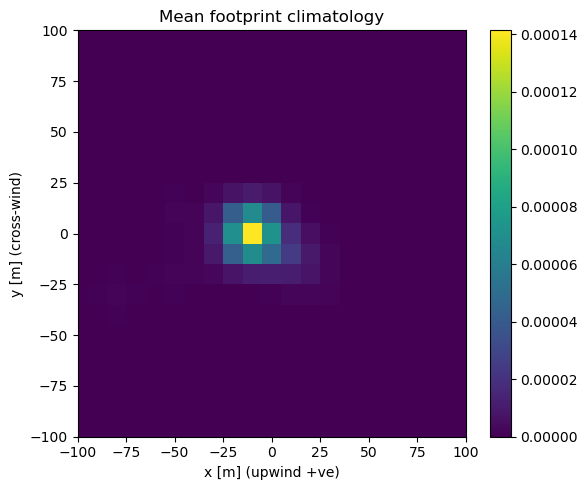

In [16]:
plt.figure(figsize=(6,5))
f_clim.plot.pcolormesh('x','y', cmap='viridis')
plt.title('Mean footprint climatology')
plt.xlabel('x [m] (upwind +ve)')
plt.ylabel('y [m] (cross‑wind)')
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()

## 5  Source‑area contours (e.g. 50 % & 80 %)

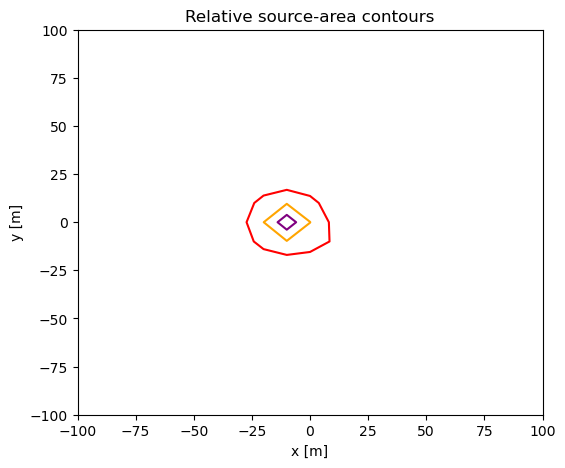

In [19]:
import numpy as np
fig, ax = plt.subplots(figsize=(6,5))
cs = ax.contour(model.xv, model.yv, f_clim, levels=[np.max(f_clim)*l for l in [0.2, 0.5, 0.8]], colors=['red','orange','purple'])
ax.clabel(cs, fmt='%1.0e')
ax.set_title('Relative source‑area contours')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
plt.show()

## 6  Batch processing multiple time steps
If you need footprints for every half‑hour over many years:

```python
for i, row in big_df.iterrows():
    try:
        fp = FFPModel(pd.DataFrame([row]), inst_height=..., crop_height=..., ...)
        clim = fp.calc_xr_footprint()
        # store or aggregate climatologies here
    except ValueError as e:
        print(f'Skipping {i}:', e)
```

## 7  Advanced options
- **Roughness sub‑layer correction**: set `rslayer=True` to enable.
- **Grid resolution**: control via `dx`, `dy`, `nx`, `ny`.
- **Footprint percentiles**: use `get_source_area_contour(r, ...)` to extract contour datasets for chosen cumulative contributions.
- **Smoothing**: switch off by `smooth_data=False` to inspect raw model output.


## 8  References
- Kljun, N. *et al.* 2015. *A simple two‑dimensional parameterisation for Flux Footprint Prediction (FFP).* **GMD**, 8, 3695‑3713.
- Schmid, H. P. 2002. *Footprint modelling for vegetation atmosphere exchange studies: a review.* **Agric. For. Meteorol.**
